In [1]:
from fastkan import FastKAN as KAN

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

from fastkan import FastKAN as KAN

from tqdm import tqdm
tqdm.pandas()

from sklearn.model_selection import train_test_split

import torchtext
torchtext.disable_torchtext_deprecation_warning()

from torchtext.datasets import IMDB
from transformers import GPT2Tokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kaloq\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kaloq\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kaloq\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
data = pd.read_csv('./imdb.csv')
data.head()

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

In [4]:
# Convert labels to binary
def transform_label(label):
    return 1 if label == 'positive' else 0

data['label'] = data['sentiment'].progress_apply(transform_label)
data.head()

100%|██████████| 50000/50000 [00:00<00:00, 1108197.00it/s]


review sentiment  label
0  One of the other reviewers has mentioned that ...  positive      1
1  A wonderful little production. <br /><br />The...  positive      1
2  I thought this was a wonderful way to spend ti...  positive      1
3  Basically there's a family where a little boy ...  negative      0
4  Petter Mattei's "Love in the Time of Money" is...  positive      1

In [5]:
# Check for dataset imbalance
data.sentiment.value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [6]:
# Review token length
data['token_length'] = data.review.progress_apply(lambda x: len(x.split()))
data.head()

100%|██████████| 50000/50000 [00:00<00:00, 104854.30it/s]


review sentiment  label  \
0  One of the other reviewers has mentioned that ...  positive      1   
1  A wonderful little production. <br /><br />The...  positive      1   
2  I thought this was a wonderful way to spend ti...  positive      1   
3  Basically there's a family where a little boy ...  negative      0   
4  Petter Mattei's "Love in the Time of Money" is...  positive      1   

   token_length  
0           307  
1           162  
2           166  
3           138  
4           230

In [7]:
data_pos = data[data['label'] == 1]
print("Positive review length")
data_pos['token_length'].describe()

Positive review length


count    25000.000000
mean       232.849320
std        177.497046
min         10.000000
25%        125.000000
50%        172.000000
75%        284.000000
max       2470.000000
Name: token_length, dtype: float64

In [8]:
data_neg = data[data['label'] == 0]
print("Negative review length")
data_neg['token_length'].describe()

Negative review length


count    25000.000000
mean       229.464560
std        164.947795
min          4.000000
25%        128.000000
50%        174.000000
75%        278.000000
max       1522.000000
Name: token_length, dtype: float64

In [9]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    
    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)

    # 
    words = word_tokenize(text)
    sent = [word for word in words if word not in stop_words]
    sent = ' '.join(sent)
    
    return sent

In [10]:
# Preprocessing
data['clean'] = data.review.progress_apply(preprocess_text)
data.head()

100%|██████████| 50000/50000 [00:25<00:00, 1990.17it/s]


review sentiment  label  \
0  One of the other reviewers has mentioned that ...  positive      1   
1  A wonderful little production. <br /><br />The...  positive      1   
2  I thought this was a wonderful way to spend ti...  positive      1   
3  Basically there's a family where a little boy ...  negative      0   
4  Petter Mattei's "Love in the Time of Money" is...  positive      1   

   token_length                                              clean  
0           307  one reviewers mentioned watching 1 oz episode ...  
1           162  wonderful little production filming technique ...  
2           166  thought wonderful way spend time hot summer we...  
3           138  basically family little boy jake thinks zombie...  
4           230  petter mattei love time money visually stunnin...

In [11]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [12]:
tokenizer.pad_token = tokenizer.eos_token
max_l = 250
data['tokenized'] = data.clean.progress_apply(lambda x: tokenizer.encode(text=x, add_special_tokens=False, truncation=True, add_prefix_space=True, padding='max_length', max_length=max_l))

100%|██████████| 50000/50000 [00:32<00:00, 1554.87it/s]


In [13]:
data.head

<bound method NDFrame.head of                                                   review sentiment  label  \
0      One of the other reviewers has mentioned that ...  positive      1   
1      A wonderful little production. <br /><br />The...  positive      1   
2      I thought this was a wonderful way to spend ti...  positive      1   
3      Basically there's a family where a little boy ...  negative      0   
4      Petter Mattei's "Love in the Time of Money" is...  positive      1   
...                                                  ...       ...    ...   
49995  I thought this movie did a down right good job...  positive      1   
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative      0   
49997  I am a Catholic taught in parochial elementary...  negative      0   
49998  I'm going to have to disagree with the previou...  negative      0   
49999  No one expects the Star Trek movies to be high...  negative      0   

       token_length                          

In [14]:
# Check actual tokenized text len
data['ct_length'] = data.tokenized.progress_apply(lambda x: len(x))
data_pos = data[data['label'] == 1]
data_pos['ct_length'].describe()

100%|██████████| 50000/50000 [00:00<00:00, 665065.80it/s]


count    25000.0
mean       250.0
std          0.0
min        250.0
25%        250.0
50%        250.0
75%        250.0
max        250.0
Name: ct_length, dtype: float64

In [15]:
# split the data
X = data.tokenized
y = data.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=39)

# Convert to tensors
X_train_tensor = torch.tensor(X_train.tolist()).to(device)
X_test_tensor = torch.tensor(X_test.tolist()).to(device)
y_train_tensor = torch.tensor(y_train.tolist()).to(device)
y_test_tensor = torch.tensor(y_test.tolist()).to(device)

# Create Datasets - tensors
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [16]:
# Batch the data
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [21]:
class SentimentCNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(SentimentCNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        # convolutional layers with batch Normalization
        self.conv1 = nn.Conv2d(1, 100, (1, embed_dim), padding=(0, 0))  # 1-gram
        self.bn1 = nn.BatchNorm2d(100)
        
        self.conv2 = nn.Conv2d(1, 100, (3, embed_dim), padding=(1, 0))  # 3-gram
        self.bn2 = nn.BatchNorm2d(100)
        
        self.conv3 = nn.Conv2d(1, 100, (5, embed_dim), padding=(2, 0))  # 5-gram
        self.bn3 = nn.BatchNorm2d(100)
        
        self.dropout = nn.Dropout(0.5)
        # Replace dense layers with FastKAN
        self.kan = KAN([37500, 512, 128, num_class], num_grids=4)

    def forward(self, text):
        embedded = self.embedding(text).unsqueeze(1)  # Add channel dimension
        
        conv1_out = F.relu(self.bn1(self.conv1(embedded))).squeeze(3)
        conv2_out = F.relu(self.bn2(self.conv2(embedded))).squeeze(3)
        conv3_out = F.relu(self.bn3(self.conv3(embedded))).squeeze(3)
        
        pooled1 = F.max_pool1d(conv1_out, 2).squeeze(2)
        pooled2 = F.max_pool1d(conv2_out, 2).squeeze(2)
        pooled3 = F.max_pool1d(conv3_out, 2).squeeze(2)

        cat = torch.cat((pooled1, pooled2, pooled3), 1)
        cat = cat.view(cat.size(0), -1)
        cat = self.dropout(cat)
        
        # Use kan for final classification
        out = self.kan(cat)
        return out


# Hyperparams
vocab_size = len(tokenizer)  # Vocabulary size of GPT-2 tokenizer
embed_dim = 128  # Embedding dimension
num_class = 2  # Number of classes (negative, positive)

model = SentimentCNNModel(vocab_size, embed_dim, num_class)
model.to(device)

SentimentCNNModel(
  (embedding): Embedding(50257, 128)
  (conv1): Conv2d(1, 100, kernel_size=(1, 128), stride=(1, 1))
  (bn1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(1, 100, kernel_size=(3, 128), stride=(1, 1), padding=(1, 0))
  (bn2): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(1, 100, kernel_size=(5, 128), stride=(1, 1), padding=(2, 0))
  (bn3): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (kan): FastKAN(
    (layers): ModuleList(
      (0): FastKANLayer(
        (layernorm): LayerNorm((37500,), eps=1e-05, elementwise_affine=True)
        (rbf): RadialBasisFunction()
        (spline_linear): SplineLinear(in_features=150000, out_features=512, bias=False)
        (base_linear): Linear(in_features=37500, out_features=512, bias=True)
      )
      (1): FastKANLayer(
        (layernorm): LayerNo

In [22]:
# Evaluation function
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    with torch.no_grad():
        for texts, labels in test_loader:
            outputs = model(texts)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            correct += calculate_accuracy(outputs, labels)
            total += labels.size(0)
    accuracy = correct / total
    avg_loss = total_loss / total
    return accuracy, avg_loss

In [23]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Learning rate decay
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

# Accuracy calculation
def calculate_accuracy(preds, labels):
    _, predicted = torch.max(preds, 1)
    correct = (predicted == labels).sum().item()
    return correct

# Training loop
num_epochs = 20
model_history = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
        for texts, labels in pbar:
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            correct_predictions += calculate_accuracy(outputs, labels)
            total_predictions += labels.size(0)
            
            accuracy = correct_predictions / total_predictions
            
            pbar.set_postfix(loss=total_loss/total_predictions, accuracy=accuracy)
    scheduler.step()

    model_history.append(evaluate(model, test_loader))
    print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}, Accuracy: {accuracy}')
    print(f'Val_Loss: {model_history[epoch][1]}, Val_Accuracy: {model_history[epoch][0]}')


Epoch 1/20: 100%|██████████| 625/625 [00:23<00:00, 27.00it/s, accuracy=0.532, loss=0.0195]


Epoch 1, Loss: 1.2475259338378906, Accuracy: 0.5318
Val_Loss: 0.010372599488496781, Val_Accuracy: 0.6105


Epoch 2/20: 100%|██████████| 625/625 [00:24<00:00, 25.02it/s, accuracy=0.78, loss=0.0072]  


Epoch 2, Loss: 0.460766695022583, Accuracy: 0.779625
Val_Loss: 0.0055926430106163025, Val_Accuracy: 0.8439


Epoch 3/20: 100%|██████████| 625/625 [00:25<00:00, 24.37it/s, accuracy=0.862, loss=0.00503]


Epoch 3, Loss: 0.3216562830686569, Accuracy: 0.862425
Val_Loss: 0.006182829217612744, Val_Accuracy: 0.8293


Epoch 4/20: 100%|██████████| 625/625 [00:24<00:00, 25.70it/s, accuracy=0.899, loss=0.00382]


Epoch 4, Loss: 0.24426524521112442, Accuracy: 0.899375
Val_Loss: 0.005140885496139527, Val_Accuracy: 0.8663


Epoch 5/20: 100%|██████████| 625/625 [00:26<00:00, 23.71it/s, accuracy=0.924, loss=0.00306]


Epoch 5, Loss: 0.1959482737660408, Accuracy: 0.924025
Val_Loss: 0.004635397137701511, Val_Accuracy: 0.8797


Epoch 6/20: 100%|██████████| 625/625 [00:22<00:00, 27.42it/s, accuracy=0.93, loss=0.00277] 


Epoch 6, Loss: 0.17714131348729134, Accuracy: 0.9302
Val_Loss: 0.0045106540396809575, Val_Accuracy: 0.8832


Epoch 7/20: 100%|██████████| 625/625 [00:22<00:00, 27.46it/s, accuracy=0.944, loss=0.00229]


Epoch 7, Loss: 0.1465006540119648, Accuracy: 0.943925
Val_Loss: 0.005999896053224802, Val_Accuracy: 0.8616


Epoch 8/20: 100%|██████████| 625/625 [00:22<00:00, 27.41it/s, accuracy=0.957, loss=0.0018] 


Epoch 8, Loss: 0.11501004141271115, Accuracy: 0.956575
Val_Loss: 0.00511689933091402, Val_Accuracy: 0.8872


Epoch 9/20: 100%|██████████| 625/625 [00:22<00:00, 27.42it/s, accuracy=0.96, loss=0.00166] 


Epoch 9, Loss: 0.1064115800768137, Accuracy: 0.959625
Val_Loss: 0.005274378863722086, Val_Accuracy: 0.8828


Epoch 10/20: 100%|██████████| 625/625 [00:23<00:00, 26.90it/s, accuracy=0.971, loss=0.00129]


Epoch 10, Loss: 0.08249570577442646, Accuracy: 0.9706
Val_Loss: 0.005913208547979594, Val_Accuracy: 0.8797


Epoch 11/20: 100%|██████████| 625/625 [00:23<00:00, 26.97it/s, accuracy=0.976, loss=0.00105]


Epoch 11, Loss: 0.06697832765802741, Accuracy: 0.9764
Val_Loss: 0.005903329094871878, Val_Accuracy: 0.8822


Epoch 12/20: 100%|██████████| 625/625 [00:22<00:00, 27.40it/s, accuracy=0.979, loss=0.000909]


Epoch 12, Loss: 0.058153787998855115, Accuracy: 0.978825
Val_Loss: 0.006366675122082234, Val_Accuracy: 0.8822


Epoch 13/20: 100%|██████████| 625/625 [00:23<00:00, 26.83it/s, accuracy=0.982, loss=0.000804]


Epoch 13, Loss: 0.05146224419698119, Accuracy: 0.982175
Val_Loss: 0.0068796430714428425, Val_Accuracy: 0.8833


Epoch 14/20: 100%|██████████| 625/625 [00:22<00:00, 27.18it/s, accuracy=0.985, loss=0.000683]


Epoch 14, Loss: 0.04369631281848997, Accuracy: 0.985225
Val_Loss: 0.006823083554208279, Val_Accuracy: 0.8831


Epoch 15/20: 100%|██████████| 625/625 [00:22<00:00, 27.40it/s, accuracy=0.987, loss=0.000608]


Epoch 15, Loss: 0.03891468771547079, Accuracy: 0.986525
Val_Loss: 0.00715560372620821, Val_Accuracy: 0.8825


Epoch 16/20: 100%|██████████| 625/625 [00:22<00:00, 27.34it/s, accuracy=0.988, loss=0.000544]


Epoch 16, Loss: 0.03482145113199949, Accuracy: 0.988425
Val_Loss: 0.007650205907225609, Val_Accuracy: 0.8798


Epoch 17/20: 100%|██████████| 625/625 [00:22<00:00, 27.40it/s, accuracy=0.989, loss=0.000492]


Epoch 17, Loss: 0.031519670474343, Accuracy: 0.988925
Val_Loss: 0.007606489586830139, Val_Accuracy: 0.8834


Epoch 18/20: 100%|██████████| 625/625 [00:23<00:00, 26.99it/s, accuracy=0.99, loss=0.000452] 


Epoch 18, Loss: 0.028918760341592135, Accuracy: 0.9901
Val_Loss: 0.008180114146322012, Val_Accuracy: 0.8814


Epoch 19/20: 100%|██████████| 625/625 [00:25<00:00, 24.23it/s, accuracy=0.991, loss=0.000415]


Epoch 19, Loss: 0.026575068703200668, Accuracy: 0.99085
Val_Loss: 0.008005782485753298, Val_Accuracy: 0.8809


Epoch 20/20: 100%|██████████| 625/625 [00:23<00:00, 26.32it/s, accuracy=0.992, loss=0.000382]


Epoch 20, Loss: 0.024416555428132414, Accuracy: 0.991525
Val_Loss: 0.008377072214335203, Val_Accuracy: 0.8831


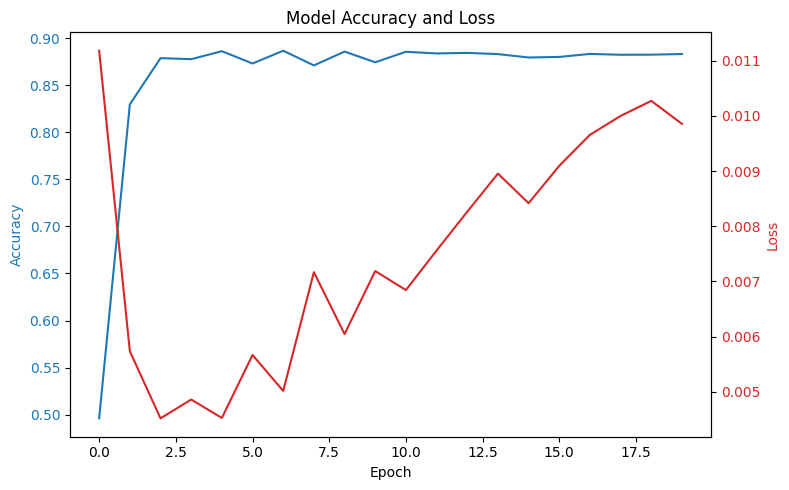

In [24]:
import matplotlib.pyplot as plt

#Plot val acc and loss
accuracy = [entry[0] for entry in model_history]
loss = [entry[1] for entry in model_history]

fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot accuracy on primary y
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.plot(accuracy, label='Accuracy', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Plot the loss on secondary y
ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='tab:red')
ax2.plot(loss, label='Loss', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Model Accuracy and Loss')
fig.tight_layout()
plt.show()